In [1]:
import timm
import numpy as np
import pandas as pd
import time
import torch
from tqdm.notebook import tqdm 

#import torch.utils.benchmark as benchmark
from torch.utils.data import Dataset, DataLoader

In [2]:
WARM_UP = 10
BATCH_SIZE = 4
NUM_TEST = 100

In [3]:
!nvidia-smi

Wed Jun  8 09:21:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:09:00.0 Off |                  Off |
| 30%   52C    P8    20W / 300W |     38MiB / 48682MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
df_models = pd.read_csv("results-imagenet-real.csv")
# use models with img size 224
modellist = df_models[df_models["img_size"]==224]["model"]
df_models.head()

,model,top1,top1_err,top5,top5_err,param_count,img_size,cropt_pct,interpolation,top1_diff,top5_diff,rank_diff
0,beit_large_patch16_512,90.689,9.311,98.751,1.249,305.67,512,1.00,bicubic,2.089,0.095,0
1,beit_large_patch16_384,90.610,9.390,98.766,1.234,305.00,384,1.00,bicubic,2.206,0.158,0
2,volo_d5_512,90.608,9.392,98.698,1.302,296.09,512,1.15,bicubic,3.566,0.730,7
3,volo_d5_448,90.582,9.418,98.685,1.315,295.91,448,1.15,bicubic,3.630,0.745,8
4,tf_efficientnet_l2_ns,90.563,9.437,98.779,1.221,480.31,800,0.96,bicubic,2.215,0.131,-2


In [5]:
class RandomDataset(Dataset):
    def __init__(self,  length, imsize):
        self.len = length
        self.data = torch.randn( 3, imsize, imsize, length)

    def __getitem__(self, index):
        return self.data[:,:,:,index]

    def __len__(self):
        return self.len

rand_loader = DataLoader(dataset=RandomDataset(BATCH_SIZE*(WARM_UP + NUM_TEST), 224),
                         batch_size=BATCH_SIZE, shuffle=False,num_workers=8)

In [6]:
# https://github.com/ryujaehun/pytorch-gpu-benchmark/blob/master/benchmark_models.py
def inference(modelname, benchmark, half=False):
    with torch.no_grad():
        model = timm.create_model(modelname,)
        model=model.to('cuda')
        model.eval()
        precision = "float"
        durations = []
        print(f'Benchmarking Inference {modelname} ')
        for step,img in enumerate(rand_loader):
            img=getattr(img,precision)()
            torch.cuda.synchronize()
            start = time.time()
            model(img.to('cuda'))
            torch.cuda.synchronize()
            end = time.time()
            if step >= WARM_UP:
                durations.append((end - start)*1000)
        print(f'{modelname} model average inference time : {sum(durations)/len(durations)}ms')
        
        if half:
            durations_half = []
            print(f'Benchmarking Inference half precision type {modelname} ')
            model.half()
            precision = "half"
            for step,img in enumerate(rand_loader):
                img=getattr(img,precision)()
                torch.cuda.synchronize()
                start = time.time()
                model(img.to('cuda'))
                torch.cuda.synchronize()
                end = time.time()
                if step >= WARM_UP:
                    durations_half.append((end - start)*1000)
            print(f'{modelname} half model average inference time : {sum(durations_half)/len(durations_half)}ms')
            
        if half:
            benchmark[modelname] = {"fp32": np.mean(durations), "fp16": np.mean(durations_half), "top1": df_models[df_models["model"]==modelname]["top1"]}
        else:
            benchmark[modelname] = {"fp32": np.mean(durations), "top1": float(df_models[df_models["model"]==modelname]["top1"])}
    return benchmark

In [7]:
benchmark = {}

# inference float precision
for i,modelname in tqdm(enumerate((modellist))):
    try:
        benchmark = inference(modelname, benchmark)
    except:
        print("pass {}".format(modelname))
benchmark

0it [00:00, ?it/s]

Benchmarking Inference beit_large_patch16_224 
beit_large_patch16_224 model average inference time : 21.330020427703857ms
Benchmarking Inference convnext_xlarge_in22ft1k 
convnext_xlarge_in22ft1k model average inference time : 21.824769973754883ms
pass volo_d5_224
pass volo_d4_224
Benchmarking Inference convnext_large_in22ft1k 
convnext_large_in22ft1k model average inference time : 15.023713111877441ms
Benchmarking Inference swin_large_patch4_window7_224 
swin_large_patch4_window7_224 model average inference time : 17.223894596099854ms
Benchmarking Inference convnext_base_in22ft1k 
convnext_base_in22ft1k model average inference time : 10.011317729949951ms
pass volo_d3_224
Benchmarking Inference xcit_large_24_p8_224_dist 
xcit_large_24_p8_224_dist model average inference time : 67.19565153121948ms
Benchmarking Inference vit_base_patch8_224 
vit_base_patch8_224 model average inference time : 37.55551815032959ms
Benchmarking Inference beit_base_patch16_224 
beit_base_patch16_224 model ave

Benchmarking Inference resmlp_36_distilled_224 
resmlp_36_distilled_224 model average inference time : 8.577532768249512ms
Benchmarking Inference xcit_large_24_p16_224 
xcit_large_24_p16_224 model average inference time : 20.206291675567627ms
pass poolformer_m36
Benchmarking Inference xcit_medium_24_p16_224 
xcit_medium_24_p16_224 model average inference time : 18.9121413230896ms
Benchmarking Inference convnext_tiny_hnf 
convnext_tiny_hnf model average inference time : 5.20892858505249ms
Benchmarking Inference tnt_s_patch16_224 
tnt_s_patch16_224 model average inference time : 11.865389347076416ms
Benchmarking Inference ssl_resnext101_32x16d 
ssl_resnext101_32x16d model average inference time : 35.50900459289551ms
Benchmarking Inference vit_small_patch16_224 
vit_small_patch16_224 model average inference time : 5.314064025878906ms
Benchmarking Inference vit_small_r26_s32_224 
vit_small_r26_s32_224 model average inference time : 9.324173927307129ms
Benchmarking Inference convmixer_1536_

dpn92 model average inference time : 12.669572830200195ms
Benchmarking Inference rexnet_130 
rexnet_130 model average inference time : 8.681139945983887ms
Benchmarking Inference gluon_resnet152_v1b 
gluon_resnet152_v1b model average inference time : 14.61836576461792ms
Benchmarking Inference resnetrs50 
resnetrs50 model average inference time : 9.30058479309082ms
Benchmarking Inference dpn131 
dpn131 model average inference time : 23.13347816467285ms
Benchmarking Inference regnetx_160 
regnetx_160 model average inference time : 26.61684513092041ms
Benchmarking Inference dla102x2 
dla102x2 model average inference time : 16.012027263641357ms
Benchmarking Inference gmlp_s16_224 
gmlp_s16_224 model average inference time : 7.957139015197754ms
Benchmarking Inference gluon_seresnext50_32x4d 
gluon_seresnext50_32x4d model average inference time : 10.371260643005371ms
Benchmarking Inference skresnext50_32x4d 
skresnext50_32x4d model average inference time : 13.965444564819336ms
Benchmarking In

gluon_resnet50_v1b model average inference time : 5.709357261657715ms
Benchmarking Inference densenet161 
densenet161 model average inference time : 18.180179595947266ms
Benchmarking Inference mobilenetv2_120d 
mobilenetv2_120d model average inference time : 6.398036479949951ms
Benchmarking Inference seresnext26t_32x4d 
seresnext26t_32x4d model average inference time : 6.067569255828857ms
Benchmarking Inference tv_resnet101 
tv_resnet101 model average inference time : 10.200674533843994ms
Benchmarking Inference hardcorenas_d 
hardcorenas_d model average inference time : 7.6938605308532715ms
Benchmarking Inference seresnext26d_32x4d 
seresnext26d_32x4d model average inference time : 6.100883483886719ms
Benchmarking Inference dla60 
dla60 model average inference time : 6.960539817810059ms
Benchmarking Inference xcit_nano_12_p8_224_dist 
xcit_nano_12_p8_224_dist model average inference time : 10.60863733291626ms
Benchmarking Inference repvgg_b1g4 
repvgg_b1g4 model average inference time 

Benchmarking Inference vgg16_bn 
vgg16_bn model average inference time : 10.73566198348999ms
Benchmarking Inference semnasnet_075 
semnasnet_075 model average inference time : 5.941629409790039ms
Benchmarking Inference tv_resnet34 
tv_resnet34 model average inference time : 4.107306003570557ms
Benchmarking Inference resnet18d 
resnet18d model average inference time : 3.145148754119873ms
Benchmarking Inference mobilenetv2_100 
mobilenetv2_100 model average inference time : 4.582910537719727ms
Benchmarking Inference xcit_nano_12_p16_224_dist 
xcit_nano_12_p16_224_dist model average inference time : 10.572693347930908ms
pass vit_base_patch32_224_sam
Benchmarking Inference ssl_resnet18 
ssl_resnet18 model average inference time : 2.853367328643799ms
Benchmarking Inference tf_mobilenetv3_large_075 
tf_mobilenetv3_large_075 model average inference time : 6.057429313659668ms
Benchmarking Inference deit_tiny_patch16_224 
deit_tiny_patch16_224 model average inference time : 5.405433177947998ms


{'beit_large_patch16_224': {'fp32': 21.330020427703857, 'top1': 90.151},
 'convnext_xlarge_in22ft1k': {'fp32': 21.824769973754883, 'top1': 89.933},
 'convnext_large_in22ft1k': {'fp32': 15.023713111877441, 'top1': 89.811},
 'swin_large_patch4_window7_224': {'fp32': 17.223894596099854, 'top1': 89.792},
 'convnext_base_in22ft1k': {'fp32': 10.011317729949951, 'top1': 89.628},
 'xcit_large_24_p8_224_dist': {'fp32': 67.19565153121948, 'top1': 89.517},
 'vit_base_patch8_224': {'fp32': 37.55551815032959, 'top1': 89.427},
 'beit_base_patch16_224': {'fp32': 7.529146671295166, 'top1': 89.41},
 'vit_large_patch16_224': {'fp32': 20.30693531036377, 'top1': 89.312},
 'xcit_medium_24_p8_224_dist': {'fp32': 41.19997262954712, 'top1': 89.293},
 'xcit_small_24_p8_224_dist': {'fp32': 29.569995403289795, 'top1': 89.203},
 'swin_base_patch4_window7_224': {'fp32': 13.018548488616943, 'top1': 89.145},
 'ig_resnext101_32x48d': {'fp32': 209.78129625320435, 'top1': 89.118},
 'ig_resnext101_32x32d': {'fp32': 132.

In [8]:
df_results = pd.DataFrame(benchmark).T
df_results

,fp32,top1
beit_large_patch16_224,21.330020,90.151
convnext_xlarge_in22ft1k,21.824770,89.933
convnext_large_in22ft1k,15.023713,89.811
swin_large_patch4_window7_224,17.223895,89.792
convnext_base_in22ft1k,10.011318,89.628
...,...,...
dla46_c,5.167294,72.607
mobilenetv3_small_075,5.276763,72.325
lcnet_050,3.289807,70.393
tf_mobilenetv3_small_minimal_100,3.498294,70.111


In [9]:
df_results.to_csv("results_fp32_224.csv")

## plot

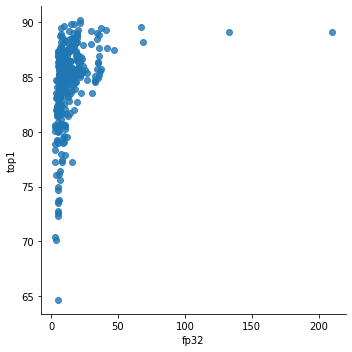

In [10]:
import seaborn as sns
sns.lmplot(y='top1', x='fp32',  
           data=df_results, logx=True,
           fit_reg=False, scatter_kws={'alpha':0.8})

# For various image size

In [11]:
# https://github.com/ryujaehun/pytorch-gpu-benchmark/blob/master/benchmark_models.py
def inference_imsize(modelname, benchmark, imsize):
    with torch.no_grad():
        model = timm.create_model(modelname,)
        model=model.to('cuda')
        model.eval()
        precision = "float"
        durations = []
        rand_loader = DataLoader(dataset=RandomDataset(BATCH_SIZE*(WARM_UP + NUM_TEST), imsize),
                         batch_size=BATCH_SIZE, shuffle=False,num_workers=8)
        print(f'Benchmarking Inference {modelname} ')
        for step,img in enumerate(rand_loader):
            img=getattr(img,precision)()
            torch.cuda.synchronize()
            start = time.time()
            model(img.to('cuda'))
            torch.cuda.synchronize()
            end = time.time()
            if step >= WARM_UP:
                durations.append((end - start)*1000)
        print(f'{modelname} model average inference time : {sum(durations)/len(durations)}ms')
        
        benchmark[modelname] = {"fp32": np.mean(durations), "top1": float(df_models[df_models["model"]==modelname]["top1"]), "imsize": imsize}
    return benchmark

In [12]:
modellist = df_models["model"]
benchmark = {}

# inference float precision
for i,modelname in tqdm(enumerate((modellist))):
    imsize = int(df_models[df_models["model"]==modelname]["img_size"])
    try:
        benchmark = inference_imsize(modelname, benchmark, imsize)
    except:
        print("pass {}".format(modelname))
benchmark

0it [00:00, ?it/s]

Benchmarking Inference beit_large_patch16_512 
beit_large_patch16_512 model average inference time : 187.91571378707886ms
Benchmarking Inference beit_large_patch16_384 
beit_large_patch16_384 model average inference time : 79.08053874969482ms
pass volo_d5_512
pass volo_d5_448
Benchmarking Inference tf_efficientnet_l2_ns 
tf_efficientnet_l2_ns model average inference time : 608.8841009140015ms
Benchmarking Inference tf_efficientnet_l2_ns_475 
tf_efficientnet_l2_ns_475 model average inference time : 255.66667079925537ms
pass volo_d4_448
Benchmarking Inference convnext_xlarge_384_in22ft1k 
convnext_xlarge_384_in22ft1k model average inference time : 56.37524366378784ms
Benchmarking Inference beit_base_patch16_384 
beit_base_patch16_384 model average inference time : 30.774567127227783ms
Benchmarking Inference convnext_large_384_in22ft1k 
convnext_large_384_in22ft1k model average inference time : 40.837438106536865ms
Benchmarking Inference vit_large_patch16_384 
vit_large_patch16_384 model 

Benchmarking Inference tf_efficientnet_b5_ap 
tf_efficientnet_b5_ap model average inference time : 32.3570990562439ms
Benchmarking Inference dm_nfnet_f1 
dm_nfnet_f1 model average inference time : 110.08667707443237ms
pass volo_d1_224
Benchmarking Inference tf_efficientnetv2_s_in21ft1k 
tf_efficientnetv2_s_in21ft1k model average inference time : 19.096014499664307ms
Benchmarking Inference vit_base_patch16_224 
vit_base_patch16_224 model average inference time : 7.161188125610352ms
Benchmarking Inference regnetz_d8 
regnetz_d8 model average inference time : 19.865193367004395ms
Benchmarking Inference resnetrs420 
resnetrs420 model average inference time : 122.50638008117676ms
Benchmarking Inference regnetz_d8_evos 
regnetz_d8_evos model average inference time : 29.344148635864258ms
Benchmarking Inference resnetrs270 
resnetrs270 model average inference time : 57.58063554763794ms
Benchmarking Inference ig_resnext101_32x16d 
ig_resnext101_32x16d model average inference time : 35.881223678

twins_pcpvt_large model average inference time : 24.546501636505127ms
Benchmarking Inference regnetz_c16 
regnetz_c16 model average inference time : 15.338287353515625ms
pass swin_s3_small_224
Benchmarking Inference deit_base_patch16_384 
deit_base_patch16_384 model average inference time : 25.87766408920288ms
Benchmarking Inference xcit_small_12_p8_224 
xcit_small_12_p8_224 model average inference time : 16.080288887023926ms
Benchmarking Inference tresnet_xl_448 
pass tresnet_xl_448
Benchmarking Inference resnetv2_50x1_bit_distilled 
resnetv2_50x1_bit_distilled model average inference time : 7.775211334228516ms
Benchmarking Inference tresnet_m 
pass tresnet_m
Benchmarking Inference twins_pcpvt_base 
twins_pcpvt_base model average inference time : 16.96429967880249ms
Benchmarking Inference gc_efficientnetv2_rw_t 
gc_efficientnetv2_rw_t model average inference time : 21.715924739837646ms
Benchmarking Inference resnetv2_101x1_bitm 
resnetv2_101x1_bitm model average inference time : 36.60

Benchmarking Inference ssl_resnext101_32x8d 
ssl_resnext101_32x8d model average inference time : 19.145667552947998ms
Benchmarking Inference coat_mini 
coat_mini model average inference time : 22.62336254119873ms
Benchmarking Inference tresnet_l 
pass tresnet_l
Benchmarking Inference twins_svt_small 
twins_svt_small model average inference time : 10.445923805236816ms
Benchmarking Inference crossvit_base_240 
crossvit_base_240 model average inference time : 10.446040630340576ms
Benchmarking Inference levit_256 
levit_256 model average inference time : 8.004951477050781ms
Benchmarking Inference seresnext50_32x4d 
seresnext50_32x4d model average inference time : 10.552456378936768ms
Benchmarking Inference crossvit_small_240 
crossvit_small_240 model average inference time : 9.910666942596436ms
Benchmarking Inference halo2botnet50ts_256 
halo2botnet50ts_256 model average inference time : 10.324373245239258ms
Benchmarking Inference pit_b_224 
pit_b_224 model average inference time : 8.09617

Benchmarking Inference ens_adv_inception_resnet_v2 
ens_adv_inception_resnet_v2 model average inference time : 28.72898817062378ms
Benchmarking Inference tf_efficientnet_lite3 
tf_efficientnet_lite3 model average inference time : 7.2660040855407715ms
Benchmarking Inference cspresnext50 
cspresnext50 model average inference time : 7.168848514556885ms
Benchmarking Inference ese_vovnet39b 
ese_vovnet39b model average inference time : 6.919662952423096ms
Benchmarking Inference gluon_resnext101_32x4d 
gluon_resnext101_32x4d model average inference time : 12.791025638580322ms
Benchmarking Inference legacy_seresnext101_32x4d 
legacy_seresnext101_32x4d model average inference time : 20.8756160736084ms
Benchmarking Inference eca_resnet33ts 
eca_resnet33ts model average inference time : 7.969191074371338ms
Benchmarking Inference xcit_tiny_24_p16_224 
xcit_tiny_24_p16_224 model average inference time : 19.108028411865234ms
Benchmarking Inference regnety_320 
regnety_320 model average inference ti

Benchmarking Inference gluon_resnet50_v1s 
gluon_resnet50_v1s model average inference time : 6.035289764404297ms
Benchmarking Inference res2net50_26w_8s 
res2net50_26w_8s model average inference time : 16.747329235076904ms
Benchmarking Inference levit_128 
levit_128 model average inference time : 7.820119857788086ms
Benchmarking Inference vit_tiny_patch16_384 
vit_tiny_patch16_384 model average inference time : 7.432727813720703ms
Benchmarking Inference gluon_resnet50_v1d 
gluon_resnet50_v1d model average inference time : 6.278553009033203ms
Benchmarking Inference dla60_res2next 
dla60_res2next model average inference time : 16.613309383392334ms
Benchmarking Inference mixnet_l 
mixnet_l model average inference time : 12.269172668457031ms
Benchmarking Inference tv_resnet152 
tv_resnet152 model average inference time : 15.204079151153564ms
Benchmarking Inference dla102x 
dla102x model average inference time : 12.948100566864014ms
Benchmarking Inference dla60_res2net 
dla60_res2net model 

Benchmarking Inference mobilenetv3_large_100_miil 
mobilenetv3_large_100_miil model average inference time : 6.05299711227417ms
Benchmarking Inference densenet201 
densenet201 model average inference time : 22.879717350006104ms
Benchmarking Inference gernet_s 
gernet_s model average inference time : 4.9816060066223145ms
Benchmarking Inference legacy_seresnext26_32x4d 
legacy_seresnext26_32x4d model average inference time : 5.817451477050781ms
Benchmarking Inference mixnet_m 
mixnet_m model average inference time : 11.988372802734375ms
Benchmarking Inference tf_efficientnet_b0 
tf_efficientnet_b0 model average inference time : 7.770888805389404ms
Benchmarking Inference hrnet_w18 
hrnet_w18 model average inference time : 30.80608367919922ms
Benchmarking Inference resnext26ts 
resnext26ts model average inference time : 6.742100715637207ms
Benchmarking Inference densenetblur121d 
densenetblur121d model average inference time : 13.999888896942139ms
Benchmarking Inference selecsls42b 
selecs

Benchmarking Inference deit_tiny_patch16_224 
deit_tiny_patch16_224 model average inference time : 5.591640472412109ms
Benchmarking Inference hrnet_w18_small 
hrnet_w18_small model average inference time : 9.659457206726074ms
Benchmarking Inference vgg19 
vgg19 model average inference time : 11.488819122314453ms
Benchmarking Inference regnetx_004 
regnetx_004 model average inference time : 9.148972034454346ms
Benchmarking Inference tf_mobilenetv3_large_minimal_100 
tf_mobilenetv3_large_minimal_100 model average inference time : 4.442019462585449ms
Benchmarking Inference legacy_seresnet18 
legacy_seresnet18 model average inference time : 4.245562553405762ms
Benchmarking Inference vgg16 
vgg16 model average inference time : 10.01007080078125ms
Benchmarking Inference vgg13_bn 
vgg13_bn model average inference time : 9.120914936065674ms
Benchmarking Inference vit_tiny_r_s16_p8_224 
vit_tiny_r_s16_p8_224 model average inference time : 5.55293083190918ms
Benchmarking Inference lcnet_100 
lcn

{'beit_large_patch16_512': {'fp32': 187.91571378707886,
  'top1': 90.689,
  'imsize': 512},
 'beit_large_patch16_384': {'fp32': 79.08053874969482,
  'top1': 90.61,
  'imsize': 384},
 'tf_efficientnet_l2_ns': {'fp32': 608.8841009140015,
  'top1': 90.563,
  'imsize': 800},
 'tf_efficientnet_l2_ns_475': {'fp32': 255.66667079925537,
  'top1': 90.54,
  'imsize': 475},
 'convnext_xlarge_384_in22ft1k': {'fp32': 56.37524366378784,
  'top1': 90.452,
  'imsize': 384},
 'beit_base_patch16_384': {'fp32': 30.774567127227783,
  'top1': 90.373,
  'imsize': 384},
 'convnext_large_384_in22ft1k': {'fp32': 40.837438106536865,
  'top1': 90.258,
  'imsize': 384},
 'vit_large_patch16_384': {'fp32': 67.05897569656372,
  'top1': 90.2,
  'imsize': 384},
 'cait_m48_448': {'fp32': 482.7632546424866, 'top1': 90.192, 'imsize': 448},
 'beit_large_patch16_224': {'fp32': 22.212607860565186,
  'top1': 90.151,
  'imsize': 224},
 'convnext_base_384_in22ft1k': {'fp32': 24.37373638153076,
  'top1': 90.151,
  'imsize': 384

In [13]:
df_results = pd.DataFrame(benchmark).T
df_results
df_results.to_csv("results_fp32_imsizeall.csv")